In [51]:
import re 
import pandas as pd 
import nltk
from nltk.collocations import *
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer, VaderConstants
import wordcloud 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt 
import random
import numpy as np

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [52]:
comments = pd.read_csv('Comments_.csv')

In [110]:
comments2 = pd.read_csv('Comments_.csv')

    Cleaning the 'Reply' coloumn from the 'Comments' table

In [62]:
comments.Reply = comments.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
##Replace cell with an empty string where the reply has been deleted
comments.Reply = comments.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))
##Create a sub dataframe where all the cells in the 'Reply' column are empty are not included for the calculations. 
comments = comments[comments.Reply != '']
comments = comments[comments.Reply != '[ deleted ]']

In [63]:
comments.head()

,Reply,Upvote,Time,Key
0,All we need now is humanless bodies,962,2018-01-30 11:19:01,1
1,For a moment I read careless driver . Would ha...,3984,2018-01-30 10:35:31,1
2,Elon 's Twitter feed has been hilarious over t...,1762,2018-01-30 11:21:32,1
5,"Jokes on us , he ’ s outsourced his Twitter ac...",64,2018-01-30 14:01:48,1
6,What a hack . Mermaid Man and Barnacle Boy hav...,179,2018-01-30 12:15:08,1


    Bigrams

In [64]:
all_text = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [65]:
all_text = nltk.word_tokenize(all_text)

    Function created to view top 10 most commonly paired words using bigram 

In [66]:
def common_bigrams(tokenized_text, min_freq, top_n):
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder = BigramCollocationFinder.from_words(tokenized_text)
    finder.apply_freq_filter(min_freq)
    finder.nbest(bigram_measures.pmi, top_n)
    return finder.nbest(bigram_measures.pmi, top_n)

print(common_bigrams(all_text, 10, 10))
    

[('Black', 'Panther'), ('social', 'media'), ('Mario', 'Kart'), ('Of', 'course'), ('license', 'plate'), ('energy', 'density'), ('body', 'kit'), ('wan', 'na'), ('gon', 'na'), ('quarter', 'mile')]


    Wordcloud Library  - Visulization of the most frequently used words

In [67]:
sample = comments.iloc[:10000,:].Reply.str.cat(sep='. ')

In [68]:
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1,20)

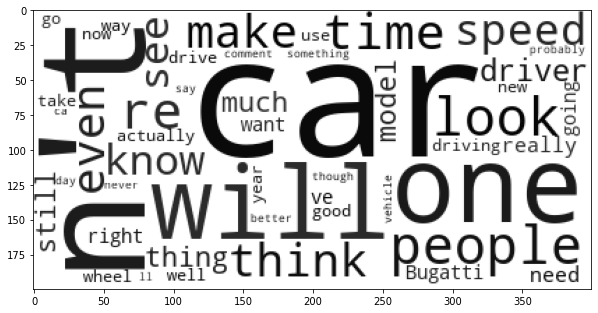

In [69]:
stp = STOPWORDS.copy()
stp.add('Tesla')
stp.add('Roadster')
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp, collocations=False)
wc.generate(sample)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

    Vader and Textblob prebuilt packages 

In [70]:
sid = SentimentIntensityAnalyzer()

In [71]:
new_words = {
    'bugatti': -1000, 
    'speed': 100, 
    'better':500, 
}

sid.lexicon.update(new_words)

In [72]:
comments[['Negative','Neutral','Positive','Compound']] = comments.Reply.apply(lambda x: pd.Series(sid.polarity_scores(x)))

In [128]:
comments['Score'] = comments['Compound'].apply(lambda c: 'positive' if c > 0 else('neutral' if c == 0 else 'negative'))

In [129]:
comments.Score.value_counts()

positive    3459
neutral     2485
negative    2125
Name: Score, dtype: int64

#    Kaggle Trained model!!

In [95]:
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer 
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [121]:
train = pd.read_csv('train.csv')

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [82]:
train.dropna(subset=['text'], inplace=True)

In [83]:
train.text = train.text.apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [107]:
stopwords = stopwords.words('english')
train.text = train.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [87]:
train.text = train.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [120]:
lemmatizer = nltk.WordNetLemmatizer()
train.text = train.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))
train.text.head()

0                         Id responded going
1                    Sooo SAD miss San Diego
2                               bos bullying
3                      interview leave alone
4    Sons couldnt put release already bought
Name: text, dtype: object

In [91]:
vectorizer = CountVectorizer()

In [92]:
X = vectorizer.fit_transform(train.text)

In [93]:
nb = MultinomialNB()
nb.fit(X, train.sentiment)

MultinomialNB()

In [97]:
yhat = nb.predict(X)
acc = metrics.accuracy_score(train.sentiment, yhat)
acc

0.8368995633187772

    Testing Naive Bayes model on Comments dataframe 

In [133]:
comments_naive = comments2

,Reply,Upvote,Time,Key
0,All we need now is humanless bodies,962,2018-01-30 11:19:01,1
1,For a moment I read careless driver . Would ha...,3984,2018-01-30 10:35:31,1
2,Elon 's Twitter feed has been hilarious over t...,1762,2018-01-30 11:21:32,1
5,"Jokes on us , he ’ s outsourced his Twitter ac...",64,2018-01-30 14:01:48,1
6,What a hack . Mermaid Man and Barnacle Boy hav...,179,2018-01-30 12:15:08,1
...,...,...,...,...
8438,It ’ s a car . It ’ s purpose is to get you fr...,1,2018-02-17 06:21:48,9
8439,Making the center screen slightly smaller and ...,1,2018-02-17 10:15:36,9
8440,"No , of course not . But there 's no reason to...",1,2018-02-17 06:55:12,9
8441,"Yes , but that screen would be pretty much use...",1,2018-02-18 00:56:58,9


In [115]:
comments_naive.Reply = comments2.Reply.apply(lambda x: re.sub(r'\(?http\S+', '', x))
comments_naive.Reply = comments2.Reply.apply(lambda x: ' '.join(nltk.word_tokenize(x)))
##Create a sub dataframe where all the cells in the 'Reply' column are empty are not included for the calculations. 
comments_naive = comments2[comments2.Reply != '']
comments_naive = comments2[comments2.Reply != '[ deleted ]']

In [116]:
comments_naive.Reply = comments_naive.Reply.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [119]:
comments_naive.Reply.head()

0                                need humanless bodies
1            moment read careless driver . Would fun .
2    Elon 's Twitter feed hilarious past day two . ...
5    Jokes us , ’ outsourced Twitter activity AI , ...
6    hack . Mermaid Man Barnacle Boy whipping one y...
Name: Reply, dtype: object

In [122]:
comments_naive = comments_naive.Reply.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

In [125]:
comments_naive_fitting = vectorizer.transform(comments_naive)
comments_naive_fitting_predictions = nb.predict(comments_naive_fitting)

array(['negative', 'negative', 'positive', ..., 'neutral', 'positive',
       'neutral'], dtype='<U8')

In [136]:
comments_naive['Score'] = comments_naive_fitting_predictions

In [140]:
comments_naive.Score.value_counts()

neutral     5234
negative    1566
positive    1269
Name: Score, dtype: int64

<AxesSubplot:title={'center':'Counts of the score for the Naive Bayes Model'}>

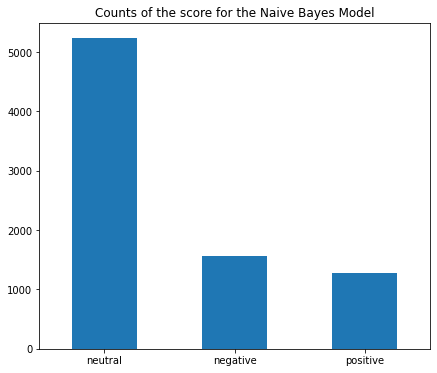

In [155]:
comments_naive.Score.value_counts().plot(kind='bar', title = 'Counts of the score for the Naive Bayes Model', figsize=(7, 6), rot=0)


<AxesSubplot:title={'center':'Counts of the score for the Vader Model'}>

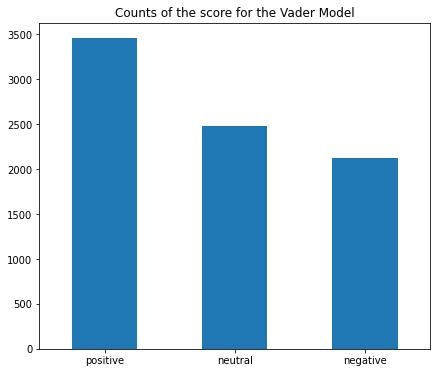

In [156]:
comments.Score.value_counts().plot(kind='bar', title = 'Counts of the score for the Vader Model', figsize=(7, 6), rot=0)

Vader Model seems to be more uniformly distributed within the 3 different categories, while neutral and negative being relatively similar. The naive Bayes model has produced a different output, as the counts bargraph appear to show that there were much more positive comments produced indicating that the algorithm treats different words very differertly. 